tgb - 11/20/2019 - The goal of this network is to code a custom interpolation layer to solve the bias where the NN misses on the upwards shift of the convective tendencies.  
1) Create a look-up table where from the lowest-level temperature, we can extract a Carnot vertical coordinate.  
2) Code up the interpolation layer in both directions in numpy  
3) Transfer that layer in tensorflow  
4) Try a few test networks using 101/100 and 104/103

# 0) Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W1122 17:18:40.266191 22766487902016 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1122 17:18:40.266810 22766487902016 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W1122 17:18:40.268527 22766487902016 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Look-up table for Carnot-like coordinate

## 1.1) Create lookup table from data

In [20]:
data0K = xr.open_mfdataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-??-0[1-2]-00000.nc",\
                    decode_times=False)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [21]:
data4K = xr.open_mfdataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.0000-??-0[1-2]-00000.nc",\
                        decode_times=False)

(array([1.00000e+00, 1.00000e+00, 6.00000e+00, 1.35000e+02, 7.71000e+02,
        2.58700e+03, 5.95300e+03, 1.05930e+04, 1.53780e+04, 1.99770e+04,
        2.49680e+04, 3.01570e+04, 3.93570e+04, 6.35400e+04, 1.08720e+05,
        1.53606e+05, 2.08548e+05, 2.73850e+05, 4.18284e+05, 6.03119e+05,
        6.72666e+05, 5.59142e+05, 3.51453e+05, 1.81566e+05, 1.20842e+05,
        1.00294e+05, 8.95330e+04, 8.22880e+04, 7.57940e+04, 7.32630e+04,
        7.10150e+04, 6.65240e+04, 6.42240e+04, 6.18790e+04, 6.03920e+04,
        5.78060e+04, 5.96590e+04, 5.67110e+04, 5.36830e+04, 5.13050e+04,
        5.41100e+04, 5.65860e+04, 5.50920e+04, 5.22480e+04, 4.98360e+04,
        5.04500e+04, 5.44790e+04, 5.53110e+04, 5.38380e+04, 5.21790e+04,
        5.06940e+04, 5.24430e+04, 5.32030e+04, 5.30860e+04, 5.32370e+04,
        5.37450e+04, 5.45810e+04, 5.48260e+04, 5.41540e+04, 5.48880e+04,
        5.65490e+04, 5.85240e+04, 5.82460e+04, 5.82040e+04, 5.70270e+04,
        5.72110e+04, 5.92920e+04, 6.12730e+04, 5.81

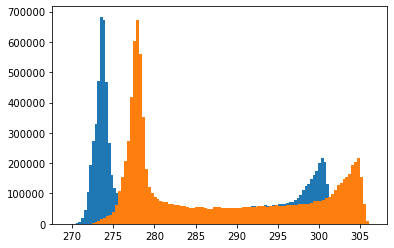

In [22]:
plt.hist(data0K.TAP[:,-1,:,:].values.flatten(),bins=100)
plt.hist(data4K.TAP[:,-1,:,:].values.flatten(),bins=100)

In [194]:
SSTrange0 = np.linspace(271,300,30).astype('int')

In [195]:
Tprof = {}
imin = {}
eps = {}
# Use reference simulation from 270K to 300K to create lookup-table there
# Matching a given NS temperature value to its corresponding temperature profile
for iSST,SST in enumerate(SSTrange0[:-1]):
    print('SST=',SST,'iSST=',iSST,'/',np.size(SSTrange0)-2,'        ',end='\r')
    if iSST==0: mask = (data0K.TAP[:,-1,:,:].values)<SSTrange0[0]
    else: mask = ((data0K.TAP[:,-1,:,:].values)>=SSTrange0[iSST])*((data0K.TAP[:,-1,:,:].values)<SSTrange0[iSST+1])
    Tref = np.mean(np.moveaxis(data0K.TAP.values,1,3)[mask],axis=0)
    Tprof[str(SST)] = Tref
    imin[str(SST)] = np.argwhere((Tref[1:]<Tref[:-1])==True)[-1][0]+1
    tmp = (-(Tref-Tref[-1])/(Tref[-1]-Tref[imin[str(SST)]]))[imin[str(SST)]:]
    eps[str(SST)] = np.maximum(0,np.minimum(1,tmp))

In [196]:
SSTrange4 = np.linspace(300,305,6).astype('int')

In [197]:
# Use reference simulation from 270K to 300K to create lookup-table there
# Matching a given NS temperature value to its corresponding temperature profile
for iSST,SST in enumerate(SSTrange4[:-1]):
    print('SST=',SST,'iSST=',iSST,'/',np.size(SSTrange4)-2,'        ',end='\r')
    mask = ((data4K.TAP[:,-1,:,:].values)>=SSTrange4[iSST])*((data4K.TAP[:,-1,:,:].values)<SSTrange4[iSST+1])
    Tref = np.mean(np.moveaxis(data4K.TAP.values,1,3)[mask],axis=0)
    Tprof[str(SST)] = Tref
    imin[str(SST)] = np.argwhere((Tref[1:]<Tref[:-1])==True)[-1][0]+1
    tmp = (-(Tref-Tref[-1])/(Tref[-1]-Tref[imin[str(SST)]]))[imin[str(SST)]:]
    eps[str(SST)] = np.maximum(0,np.minimum(1,tmp))

In [198]:
SSTrange = np.concatenate((SSTrange0,SSTrange4))

In [199]:
imin

{'271': 2,
 '272': 2,
 '273': 12,
 '274': 13,
 '275': 12,
 '276': 12,
 '277': 12,
 '278': 12,
 '279': 12,
 '280': 12,
 '281': 12,
 '282': 11,
 '283': 11,
 '284': 11,
 '285': 11,
 '286': 8,
 '287': 8,
 '288': 8,
 '289': 7,
 '290': 7,
 '291': 7,
 '292': 7,
 '293': 7,
 '294': 7,
 '295': 7,
 '296': 7,
 '297': 7,
 '298': 7,
 '299': 7,
 '300': 6,
 '301': 6,
 '302': 6,
 '303': 6,
 '304': 6}

In [200]:
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_20_Tlookup.pkl','wb')
Tlookup = {"eps":eps,"imin":imin,"Tprof":Tprof,"SSTrange":SSTrange}
pickle.dump(Tlookup,hf)
hf.close()

## 1.2) Create analytical fit for ease of use
The goal is to fit a reference epsilon profile and a imin index to a given NS temperature value

### 1.2.1) Fit imin(T_NS)

In [237]:
imin_data = []
TNS_data= []
for i,key in enumerate(imin.keys()):
    imin_data = np.concatenate((imin_data,[imin[key]]))
    TNS_data = np.concatenate((TNS_data,[Tprof[key][-1]]))

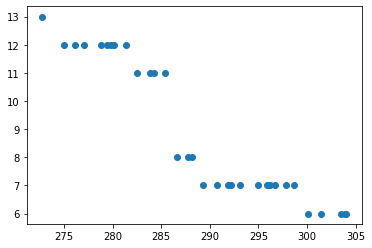

In [202]:
plt.scatter(TNS_data[2:],imin_data[2:])

Fit polynomial to data above as test

In [203]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [204]:
degree = 4
model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [205]:
model = model.fit(TNS_data[2:][:,np.newaxis],imin_data[2:][:,np.newaxis])
model.named_steps['linear'].coef_

array([[-6.21042563e-01, -4.47699171e+01,  4.73394145e-01,
        -1.66233823e-03,  1.94015714e-06]])

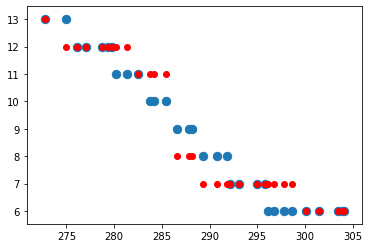

In [206]:
plt.scatter(TNS_data[2:][:,np.newaxis],np.rint(model.predict(TNS_data[2:][:,np.newaxis])),s=70)
plt.scatter(TNS_data[2:],imin_data[2:],color='r')

In [207]:
model2 = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [208]:
model2 = model2.fit(np.log10(TNS_data[2:][:,np.newaxis]),np.log10(imin_data[2:][:,np.newaxis]))
model2.named_steps['linear'].coef_

array([[-17282213.25055097,  28052693.30790144, -17075450.69514675,
          4619325.45836546,   -468605.77829288]])

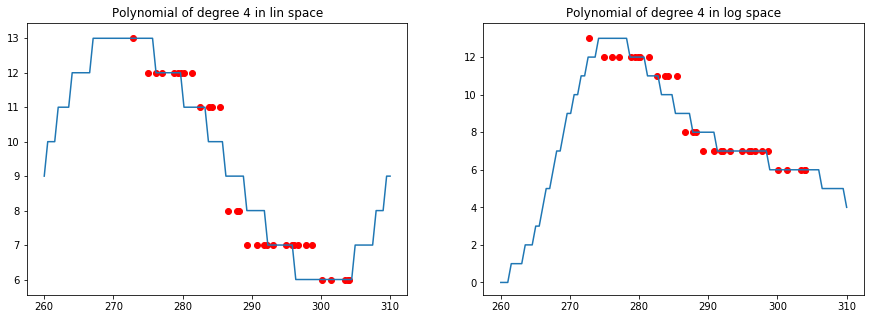

In [209]:
T_data = np.linspace(260,310,100)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Polynomial of degree '+str(degree)+' in lin space')
plt.plot(T_data[:,np.newaxis],np.rint(model.predict(T_data[:,np.newaxis])))
plt.scatter(TNS_data[2:],imin_data[2:],color='r')

plt.subplot(1,2,2)
plt.title('Polynomial of degree '+str(degree)+' in log space')
plt.plot(T_data[:,np.newaxis],np.rint(10**model2.predict(np.log10(T_data[:,np.newaxis]))))
plt.scatter(TNS_data[2:],imin_data[2:],color='r')

Model coefficients

In [210]:
# pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
# hf = open(pathPKL+'2019_11_22_imin_TNS_logfit.pkl','wb')
# tosave = {"logmodel":model2.named_steps['linear'].coef_,"linmodel":model.named_steps['linear'].coef_}
# pickle.dump(tosave,hf)
# hf.close()

In [255]:
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_22_imin_TNS_logfit.pkl','rb')
imfit = pickle.load(hf)['logmodel'][0]

In [256]:
imfit

array([-17282213.25055097,  28052693.30790144, -17075450.69514675,
         4619325.45836546,   -468605.77829288])

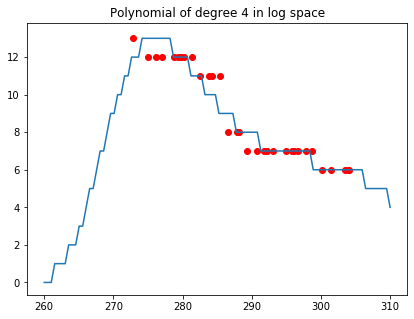

In [257]:
T_data = np.linspace(260,310,100)

plt.figure(figsize=(15,5))

# plt.subplot(1,2,1)
# plt.title('Polynomial of degree '+str(degree)+' in lin space')
# plt.plot(T_data[:,np.newaxis],np.rint(model.predict(T_data[:,np.newaxis])))
# plt.scatter(TNS_data[2:],imin_data[2:],color='r')

plt.subplot(1,2,2)
plt.title('Polynomial of degree '+str(degree)+' in log space')
x = np.log10(T_data[:,np.newaxis])
y = 10**(imfit[0]*x**0+imfit[1]*x**1+imfit[2]*x**2+imfit[3]*x**3+imfit[4]*x**4)
plt.plot(T_data[:,np.newaxis],np.rint(y))
plt.scatter(TNS_data[2:],imin_data[2:],color='r')

### 1.2.2) Fit eps(T_NS[continuous])[30 discrete levels]

In [309]:
TNS_data= []
eps_data = np.nan*np.zeros((34,30))
itot = 0
for i,key in enumerate(Tprof.keys()):
    TNS_data = np.concatenate((TNS_data,[Tprof[key][-1]]))
    eps_load = eps[key]
    imin_data = 30-eps_load.size
    for ilev in range(30):
        if ilev>=imin_data: eps_data[itot,ilev] = eps_load[ilev-imin_data]
        else: eps_data[itot,ilev] = 1
    itot += 1

In [310]:
model = {}
model2 = {}
degree = 4
for ilev in range(30):
    model[str(ilev)] = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                                 ('linear', LinearRegression(fit_intercept=False))])
    model[str(ilev)].fit(TNS_data[2:][:,np.newaxis],eps_data[2:,ilev][:,np.newaxis])
    model2[str(ilev)] = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                                 ('linear', LinearRegression(fit_intercept=False))])
    model2[str(ilev)].fit(np.log10(TNS_data[2:][:,np.newaxis]),eps_data[2:,ilev][:,np.newaxis])

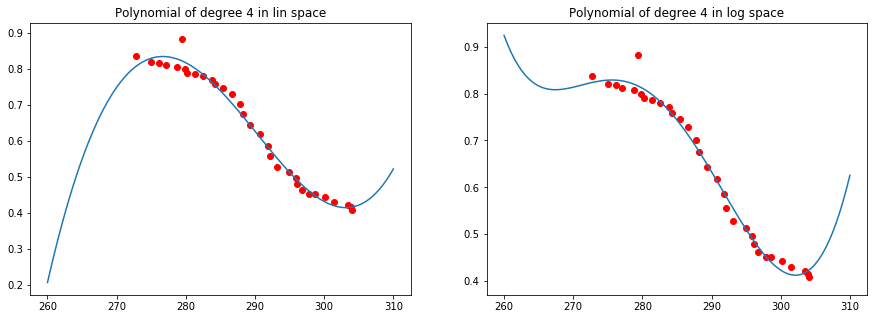

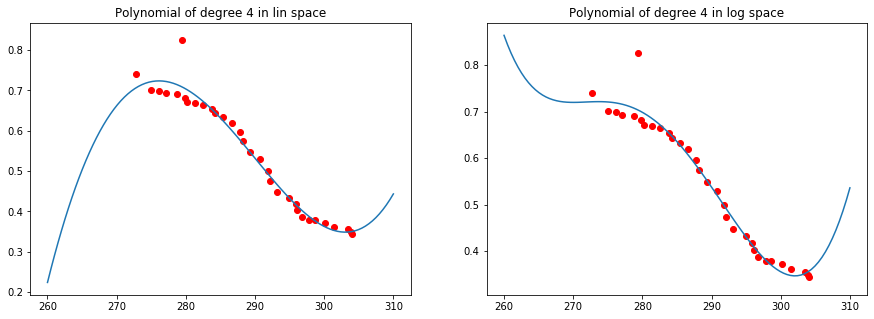

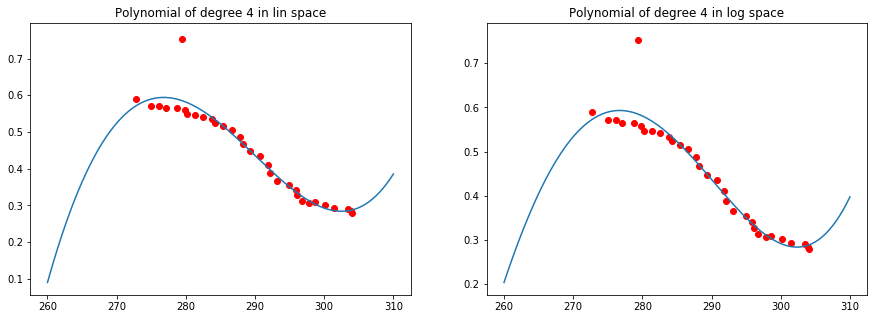

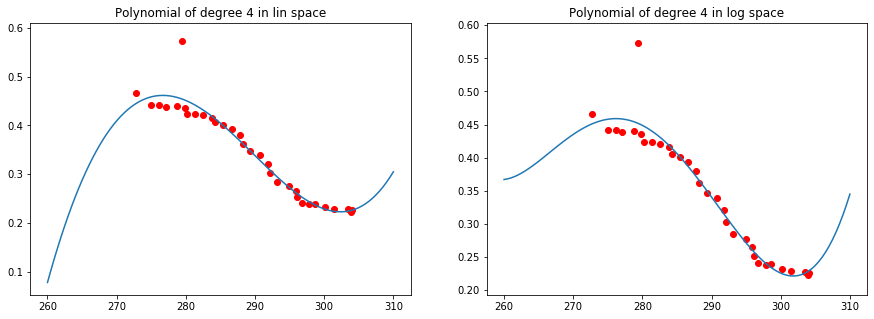

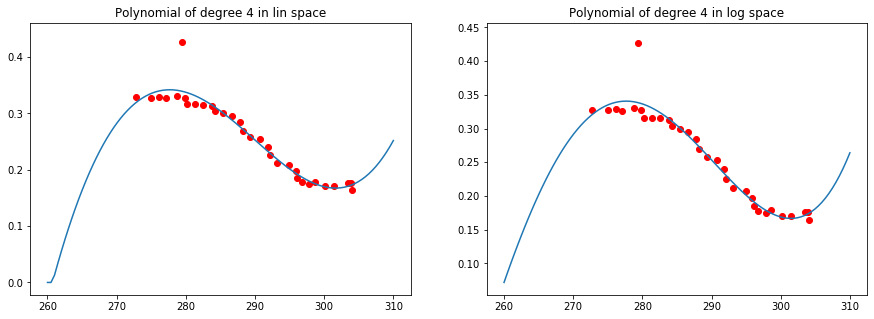

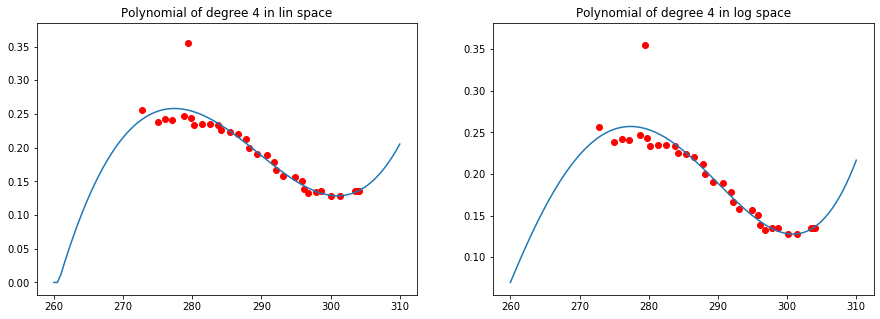

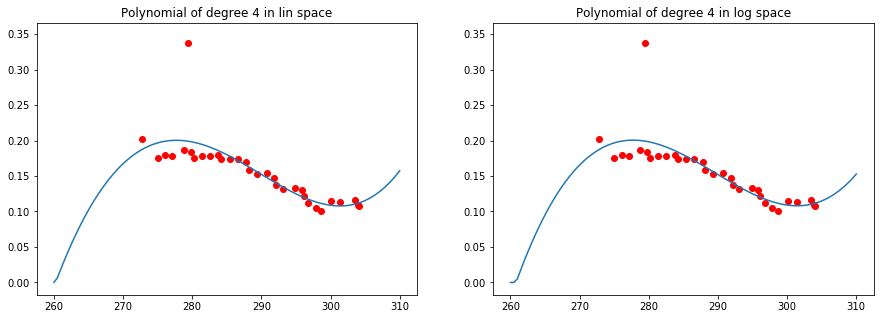

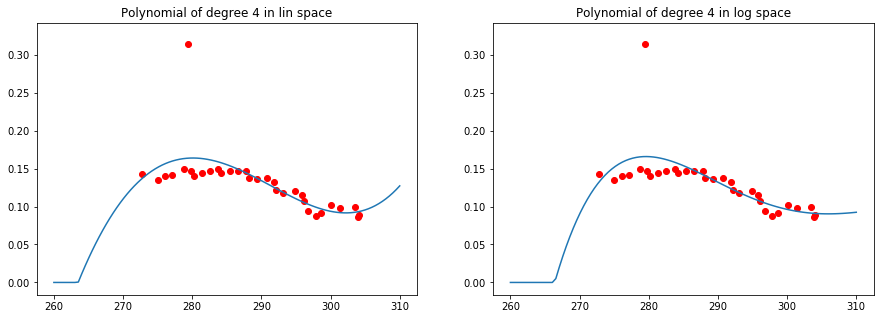

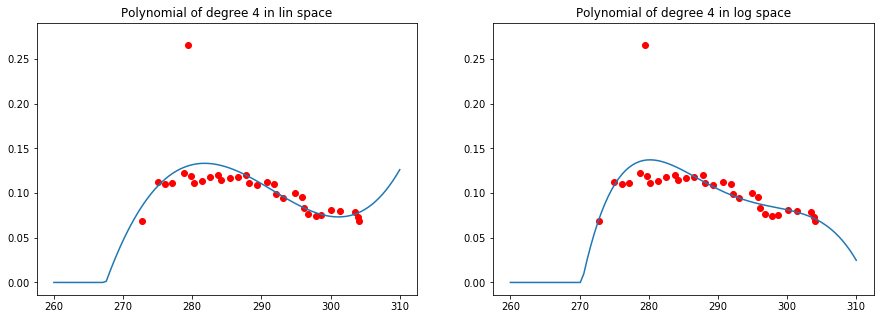

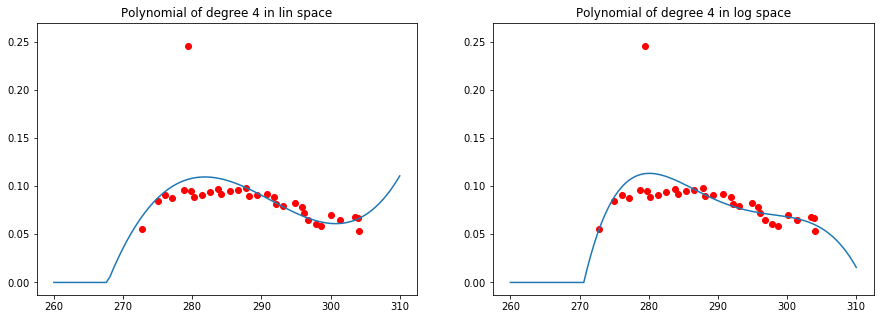

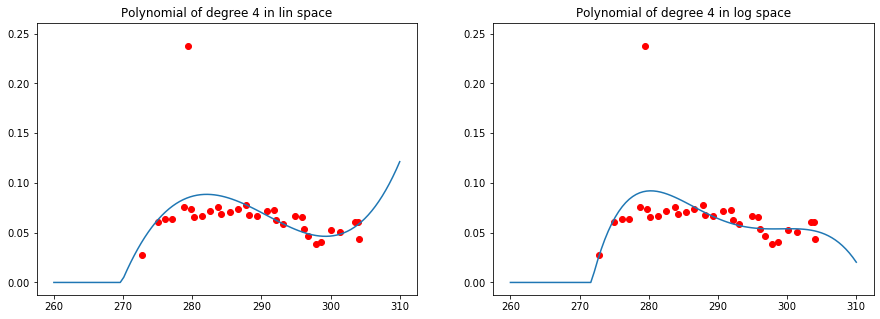

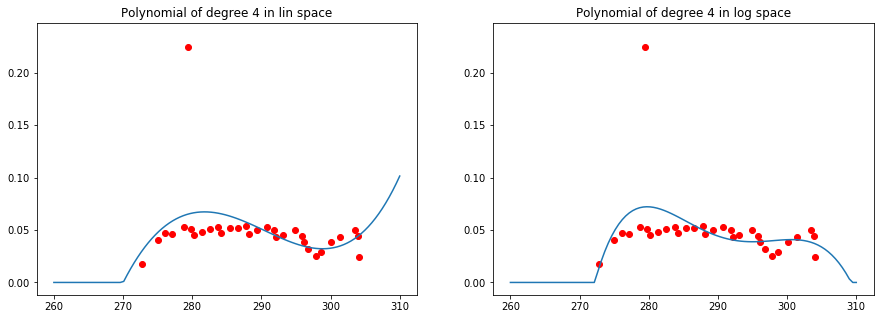

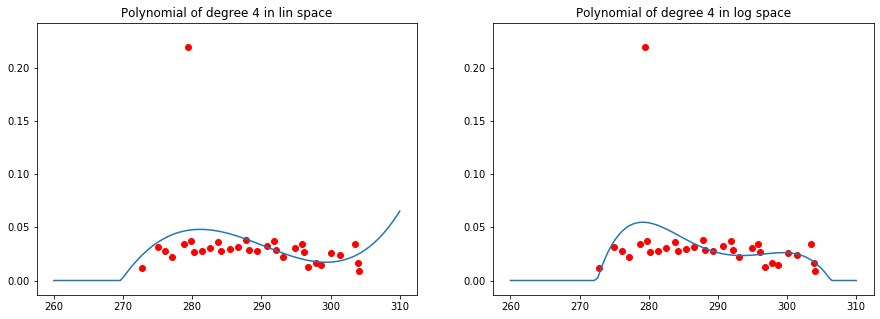

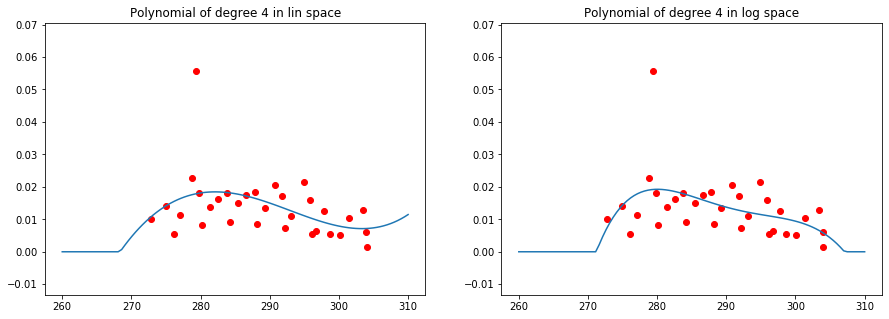

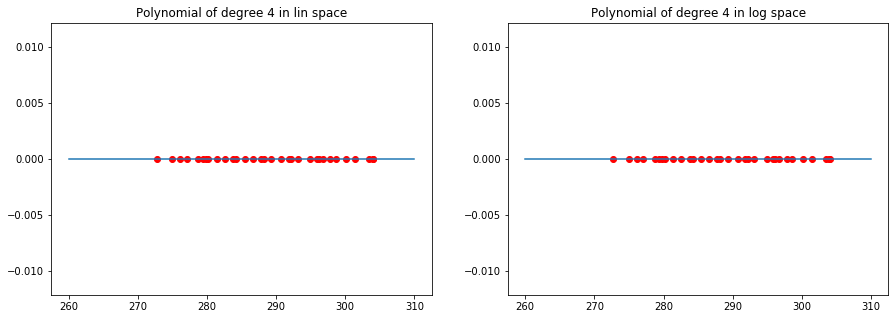

In [311]:
T_data = np.linspace(260,310,100)

for i,ilev in enumerate(np.arange(15,30)):
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title('Polynomial of degree '+str(degree)+' in lin space')
    plt.scatter(TNS_data[2:],eps_data[2:,ilev],color='r')
    y = model[str(ilev)].predict(T_data[:,np.newaxis])
    y = np.minimum(1,np.maximum(0,y))
    plt.plot(T_data[:,np.newaxis],y)

    plt.subplot(1,2,2)
    plt.title('Polynomial of degree '+str(degree)+' in log space')
    plt.scatter(TNS_data[2:],eps_data[2:,ilev],color='r')
    y = model2[str(ilev)].predict(np.log10(T_data[:,np.newaxis]))
    y = np.minimum(1,np.maximum(0,y))
    plt.plot(T_data[:,np.newaxis],y)

Model coefficients

In [312]:
print('Linear model',model['15'].named_steps['linear'].coef_)
print('Log model',model2['15'].named_steps['linear'].coef_)

Linear model [[-5.21881038e-02 -3.76215606e+00  3.91733653e-02 -1.35563248e-04
   1.56016662e-07]]
Log model [[ 10699474.21768425 -17476285.94142119  10704074.0801596
   -2913723.49035372    297413.33530232]]


Save all model coefficients in tensor

In [315]:
linmodel = np.zeros((30,5))
#logmodel = np.zeros((30,5))
for ilev in range(30):
    linmodel[ilev,:] = model[str(ilev)].named_steps['linear'].coef_

In [323]:
# pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
# hf = open(pathPKL+'2019_11_22_eps_TNS_linfit.pkl','wb')
# tosave = {"linmodel":linmodel}
# pickle.dump(tosave,hf)
# hf.close()

In [337]:
hf = open(pathPKL+'2019_11_22_eps_TNS_linfit.pkl','rb')
epfit = pickle.load(hf)['linmodel']

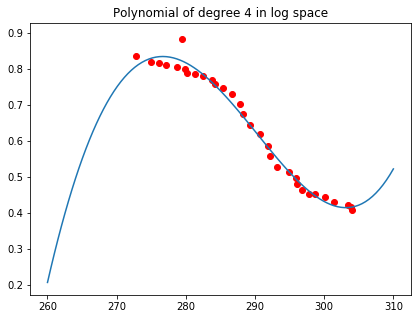

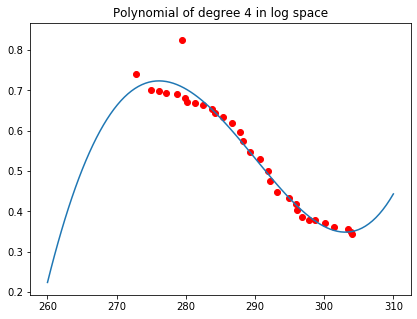

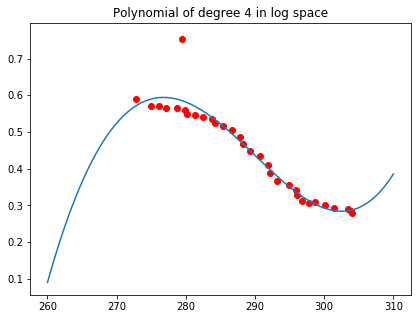

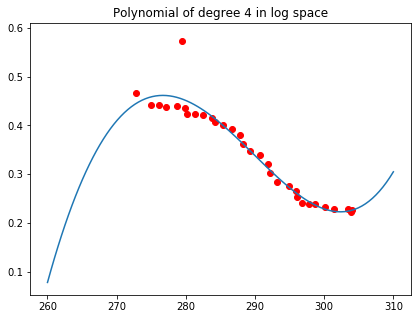

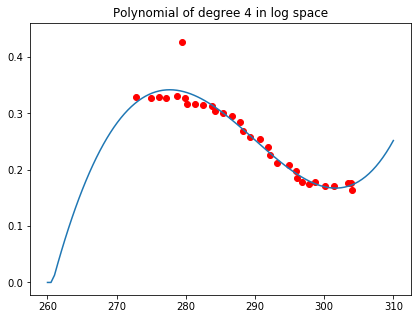

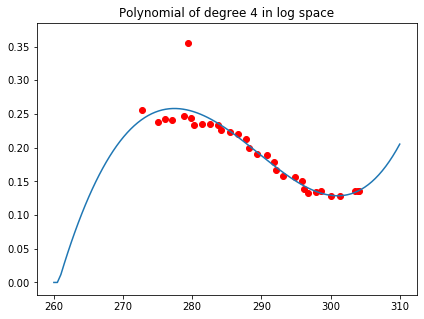

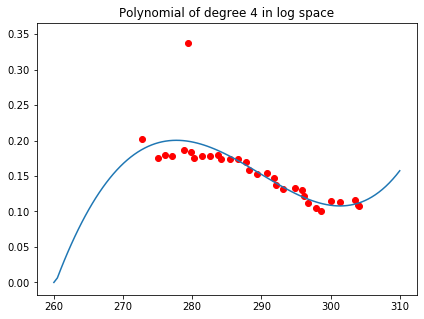

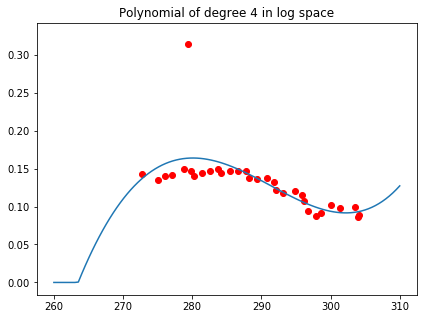

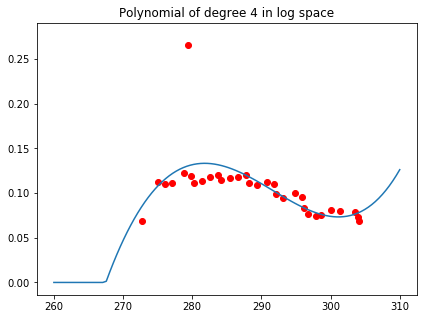

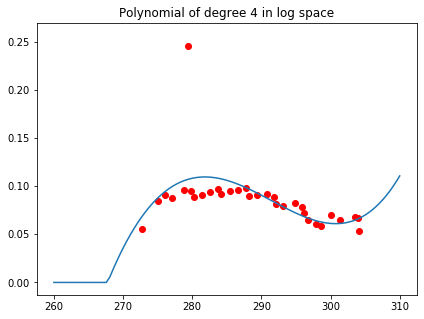

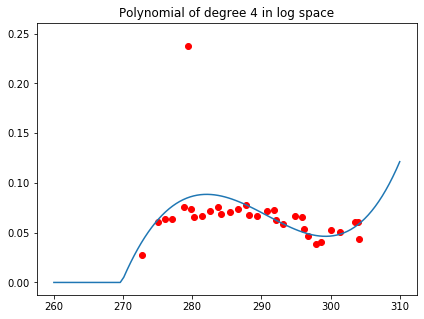

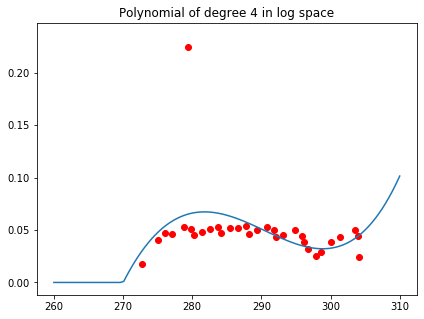

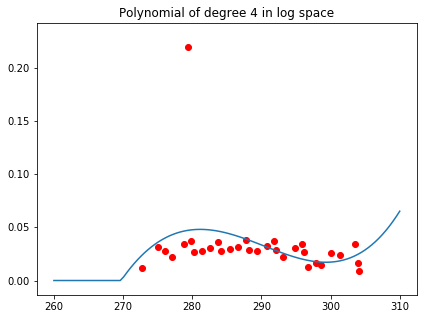

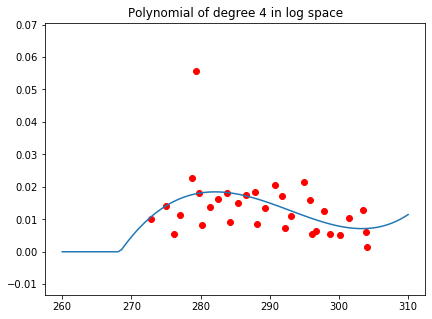

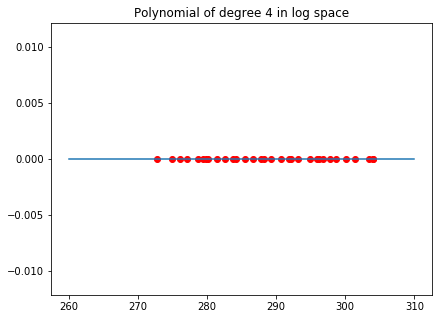

In [348]:
T_data = np.linspace(260,310,100)

for i,ilev in enumerate(np.arange(15,30)):
    plt.figure(figsize=(15,5))

#     plt.subplot(1,2,1)
#     plt.title('Polynomial of degree '+str(degree)+' in lin space')
#     plt.scatter(TNS_data[2:],eps_data[2:,ilev],color='r')
#     y = model[str(ilev)].predict(T_data[:,np.newaxis])
#     y = np.minimum(1,np.maximum(0,y))
#     plt.plot(T_data[:,np.newaxis],y)


    plt.subplot(1,2,2)
    plt.title('Polynomial of degree '+str(degree)+' in log space')
    plt.scatter(TNS_data[2:],eps_data[2:,ilev],color='r')
    x = T_data[:,np.newaxis]
    #y = model2[str(ilev)].predict(np.log10(T_data[:,np.newaxis]))
    y = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
    y = np.minimum(1,np.maximum(0,y))
    plt.plot(T_data[:,np.newaxis],y[:,ilev])

In [340]:
y.shape

(100, 30)

# 2) Numpy interpolation layers

In [317]:
#Load profile of convective heating and moistening
it = 205
ilat = 55
ilon = 25
PHQ_test = data0K.PHQ[it,:,ilat,ilon]
TPHYSTND_test = data0K.TPHYSTND[it,:,ilat,ilon]
TAP_test = data0K.TAP[it,:,ilat,ilon]

In [318]:
# Method 1: Using dictionary and lookup tables
# Load data
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_20_Tlookup.pkl','rb')
Tlookup = pickle.load(hf)
# Find closest SST
iSST = np.argmin(np.abs(Tlookup['SSTrange']-TAP_test.values[-1]))
SST = str(Tlookup['SSTrange'][iSST].astype('int'))
# Interpolate the tendencies on reference eps profile
eps_ref = np.linspace(0,1,1001)
TPHYSTND_testeps = np.interp(x=eps_ref,xp=Tlookup['eps'][SST][::-1],fp=TPHYSTND_test[Tlookup['imin'][SST]:][::-1])
PHQ_testeps = np.interp(x=eps_ref,xp=Tlookup['eps'][SST][::-1],fp=PHQ_test[Tlookup['imin'][SST]:][::-1])

In [319]:
np.expand_dims(TAP_test.values[-1],axis=1).shape

(1,)

In [364]:
# Method 2: Using fits (only tensors)
# Load data
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_22_imin_TNS_logfit.pkl','rb')
imfit = pickle.load(hf)['logmodel'][0]
hf = open(pathPKL+'2019_11_22_eps_TNS_linfit.pkl','rb')
epfit = pickle.load(hf)['linmodel']
# Interpolate the tendencies on reference profile
eps_ref = np.linspace(0,1,1001)
x = np.log10([TAP_test.values[-1]]).astype('float64')
imin_eval = np.rint(10**(imfit[0]*x**0+imfit[1]*x**1+imfit[2]*x**2+imfit[3]*x**3+imfit[4]*x**4))[0].astype('int')
x = TAP_test.values[-1]
eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
eps_eval = np.minimum(1,np.maximum(eps_eval,0))
TPHYSTND_testeps = np.interp(x=eps_ref,xp=eps_eval[imin_eval:][::-1],fp=TPHYSTND_test[imin_eval:][::-1])
PHQ_testeps = np.interp(x=eps_ref,xp=eps_eval[imin_eval:][::-1],fp=PHQ_test[imin_eval:][::-1])

Text(0.5, 1.0, 'PHQ')

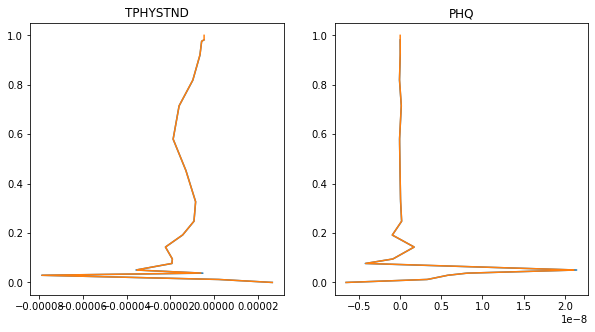

In [368]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
#plt.plot(TPHYSTND_test[Tlookup['imin'][SST]:][::-1],Tlookup['eps'][SST][::-1]) # Method 1
plt.plot(TPHYSTND_test[imin_eval:][::-1],eps_eval[imin_eval:][::-1]) # Method 2
plt.plot(TPHYSTND_testeps,eps_ref)
plt.title('TPHYSTND')

plt.subplot(1,2,2)
#plt.plot(PHQ_test[Tlookup['imin'][SST]:][::-1],Tlookup['eps'][SST][::-1]) # Method 1
plt.plot(PHQ_test[imin_eval:][::-1],eps_eval[imin_eval:][::-1]) # Method 2
plt.plot(PHQ_testeps,eps_ref)
plt.title('PHQ')

In [15]:
# Reinterpolate back
TPHYSTND_back = np.interp(x=Tlookup['eps'][SST][::-1],xp=eps_ref,fp=TPHYSTND_testeps)[::-1]
TPHYSTND_back = np.concatenate((np.zeros([Tlookup['imin'][SST]],),TPHYSTND_back))

PHQ_back = np.interp(x=Tlookup['eps'][SST][::-1],xp=eps_ref,fp=PHQ_testeps)[::-1]
PHQ_back = np.concatenate((np.zeros([Tlookup['imin'][SST]],),PHQ_back))

Text(0.5, 1.0, 'PHQ')

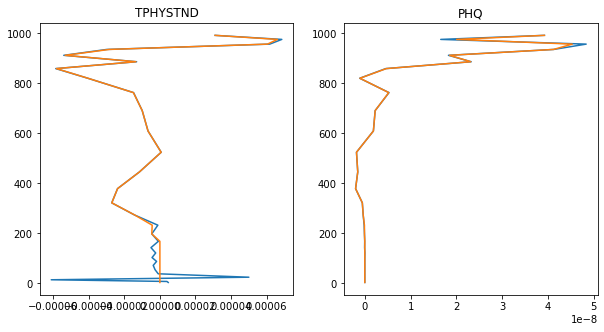

In [16]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(TPHYSTND_test,data0K.lev)
plt.plot(TPHYSTND_back,data0K.lev)
plt.title('TPHYSTND')

plt.subplot(1,2,2)
plt.plot(PHQ_test,data0K.lev)
plt.plot(PHQ_back,data0K.lev)
plt.title('PHQ')

# 3) Tensorflow layers

## 3.1) Forward interpolation layer

### 3.1.1) Mimic the layer as closely as possible with numpy

In this subsection, I am not allowed to use any numpy utility that would not be available in tensorflow/differentiable

In [17]:
# Mimics NN input x
it = np.arange(200,300)
ilat = 55
ilon = 25
x_test = np.concatenate((data0K.QAP[it,:,ilat,ilon],data0K.TAP[it,:,ilat,ilon],
                         np.expand_dims(data0K.PS[it,ilat,ilon],axis=1),
                         np.expand_dims(data0K.SOLIN[it,ilat,ilon],axis=1),
                         np.expand_dims(data0K.SHFLX[it,ilat,ilon],axis=1),
                         np.expand_dims(data0K.LHFLX[it,ilat,ilon],axis=1)),
                        axis=1)

In [18]:
x_test.shape

(100, 64)

In [35]:
# Layer input
# x = The NN input 
# x.shape=(batch size,# inputs)
# Layer output
# x_interp = The NN input interpolated on the custom eps grid
# x_interp.shape=(batch size,custom eps grid size)
# Parameters
eps_res = 1e2
# eps_res = Resolution of the eps grid

# 1) Generate eps grid for the neural network with vertical resolution eps_res
eps_NN = np.linspace(0,1,eps_res)

# 2) Extract temperature and moisture from input vector
q = x_test[:,:30]
T = x_test[:,30:60]

# 3) Find closest eps coordinate given near-surface temperature T[30]
# Assumes the lookup table Tlookup(SSTrange,eps,imin) is already loaded (e.g. using tf.data)
for isample in range(T.shape[0]):
    iSST = np.argmin(np.abs(SSTrange-T[isample,-1]))
    SST = str(SSTrange[iSST].astype('int'))
    eps_input = eps[SST][::-1]
    
# 4) Interpolate both T and q to the eps grid for the neural network
# 4.1) Thermodynamic profiles to interpolate
    T_input = T[isample,imin[SST]:]
    q_input = q[isample,imin[SST]:]
# 4.2) Interpolation using searchsorted and low-level weighting implementation
    iint = np.searchsorted(eps_input,eps_NN)
    T_interp
    stop

NameError: name 'stop' is not defined

In [37]:
eps_NN.shape

(100,)

In [38]:
eps_input.shape

(18,)

In [39]:
iint

array([ 0,  3,  4,  4,  4,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 17])

In [ ]:
eps_ref = np.linspace(0,1,1001)
TPHYSTND_testeps = np.interp(x=eps_ref,xp=eps[SST][::-1],fp=TPHYSTND_test[imin[SST]:][::-1])
PHQ_testeps = np.interp(x=eps_ref,xp=eps[SST][::-1],fp=PHQ_test[imin[SST]:][::-1])

In [18]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tfm

In [ ]:
i = searchsorted(xp, x); 
cond(eq(i, 0), left, cond(eq(i, len(xp)), right, 
                          fp[i - 1] + (fp[i] - fp[i - 1]) * (x - xp[i - 1]) / (xp[i] - xp[i - 1])))

In [19]:
tfp.math.interp_regular_1d_grid(
    x,
    x_ref_min,
    x_ref_max,
    y_ref,
    axis=-1,
    fill_value='constant_extension',
    fill_value_below=None,
    fill_value_above=None,
    grid_regularizing_transform=None,
    name=None
)

NameError: name 'x' is not defined

In [ ]:
class MassConsLayer_choice(Layer):
    def __init__(self, inp_sub, inp_div, norm_q, hyai, hybi, lvl_choice, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Added lvl_choice, a hyper-parameter to choose the level of mass conservation [0-29]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        self.lvl_choice = np.int32(lvl_choice)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        self.LHFLX_idx = 303
        # Output
        self.PHQbef_idx = slice(0, self.lvl_choice) # Indices before the residual
        self.PHCLDLIQ_idx = slice(29, 59)
        self.PHCLDICE_idx = slice(59, 89)
        self.PRECT_idx = 212
        self.PRECTEND_idx = 213

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'lvl_choice':self.lvl_choice}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, arrs):
        
        # Find closest SST
        tf.math.argmin
        iSST = tfm.argmin(tfm.abs(SSTrange-TAP_test.values[-1]))
        SST = str(SSTrange[iSST].astype('int'))
        
        # Interpolate the tendencies on reference eps profile
        eps_ref = tf.linspace(0,1,1001)
        TPHYSTND_testeps = np.interp(x=eps_ref,xp=eps[SST][::-1],fp=TPHYSTND_test[imin[SST]:][::-1])
        PHQ_testeps = np.interp(x=eps_ref,xp=eps[SST][::-1],fp=PHQ_test[imin[SST]:][::-1])
        
        tfp.math.interp_regular_1d_grid(
    x,
    x_ref_min,
    x_ref_max,
    y_ref,
    axis=-1,
    fill_value='constant_extension',
    fill_value_below=None,
    fill_value_above=None,
    grid_regularizing_transform=None,
    name=None
)
        
        
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx],
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q, self.hyai, self.hybi
        )

        # 2. Compute vertical cloud water integral
        CLDINT = K.sum(dP_tilde *
                       (prior[:, self.PHCLDLIQ_idx] + prior[:, self.PHCLDICE_idx]),
                       axis=1)

        # 3. Compute water vapor integral minus the water vapor residual
        # Careful with handling the pressure vector since it is not aligned
        # with the prior water vapor vector
        VAPINT = K.sum(dP_tilde[:, self.PHQbef_idx] * prior[:, self.PHQbef_idx], 1) +\
        K.sum(dP_tilde[:, self.lvl_choice+1:30] * prior[:, self.lvl_choice:29], 1)

        # 4. Compute forcing (see Tom's note for details, I am just copying)
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] +
                 self.inp_sub[self.LHFLX_idx])
        PREC = prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx]

        # 5. Compute water vapor tendency at level lvl_choice as residual
        PHQ_LVL = (LHFLX - PREC - CLDINT - VAPINT) / dP_tilde[:, self.lvl_choice]

        # 6. Concatenate output vector
        post = tf.concat([
            prior[:, self.PHQbef_idx], PHQ_LVL[:, None],
            prior[:, self.lvl_choice:]
        ], axis=1)
        return post

    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)